In [73]:
# Importing dependencies and libraries
import numpy as np
import json
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
import scipy.stats as st

from config import api_key
from citipy import citipy
from IPython.display import clear_output

In [3]:
# Building the 500+ cities list

# Setting ranges to look for cities
latitude_range = np.random.randint(-90,91, 10) #change 10 to 70 when testing is done
longitude_range = np.random.randint(-180,181, 10) #change 10 to 70 when testing is done

# This loop will ensure that the sample size is enough
# At least 500 (will do 550 just to be sure) cities with data are needed, 
# with a 5.8% of missing data 577 cities is the minimum sample size
test = False
while test == False:

    cities_list = []
    #nested for loop that will retrieve every city
    for x in longitude_range:
        for y in latitude_range:
            city = citipy.nearest_city(x,y)
            cities_list.append(city.city_name)
    if len(cities_list) >= 0: #change conditional to 577 after testing
        test = True
#converting the resulting list to a dataframe, dropping the duplicates and reindexing
cities_list_df = pd.DataFrame({'Cities':cities_list})
cities_list_df = cities_list_df.drop_duplicates().reset_index(drop = True)
print(f'Sample size is {len(cities_list_df.index)} list built succesfully')
cities_list_df.head(10)

Sample size is 33 list built succesfully


,Cities
0,saint-philippe
1,talcahuano
2,arraial do cabo
3,jamestown
4,lebu
5,luderitz
6,port alfred
7,tsihombe
8,dikson
9,qaanaaq


In [13]:
#API requests

# Lists initialization
latitude = []
longitude = []
temperature = []
humidity = []
cloudiness = []
wind = []
failed_cities = []

# Base URL
url = "http://api.openweathermap.org/data/2.5/weather?"

# Variable initialization for progress tracker
request_num = 0
succ_request = 0
failed_request = 0

# for loop to request data from all cities
for city in cities_list_df['Cities']:
    
    # Build query URL
    query_url = url + "appid=" + api_key + "&q=" + city + "&units=imperial"
    
    # Request data for the current city
    weather_response = requests.get(query_url)
    weather_json = weather_response.json()
    
    # Printing progress information
    clear_output(wait=True)
    request_num += 1
    print(f'Processing {city} request {request_num}/{len(cities_list_df.index)}')
    print(f'{succ_request} succesfull {failed_request} failed')
    
    # Making sure the request was succesful
    if weather_response.status_code == 200:
        # Appending current data to lists
        latitude.append(weather_json['coord']['lat'])
        longitude.append(weather_json['coord']['lon'])
        temperature.append(weather_json['main']['temp'])
        humidity.append(weather_json['main']['humidity'])
        cloudiness.append(weather_json['clouds']['all'])
        wind.append(weather_json['wind']['speed'])
        succ_request += 1
    else:
        failed_request += 1
        # Saving the failed city to be able to delete it from the dataframe
        failed_cities.append(city)
    
    # Making sure that time between requests is enough so that API key doesn't get blocked
    time.sleep(1.01)

# Print out final request results
clear_output(wait=True)   
print('API requests finished')
print(f'{succ_request} succesfull {failed_request} failed')


Processing request 33/33
28 succesfull 5 failed
API requests finished


In [16]:
# Cleanind and building the results dataframe

clean_weather_df = cities_list_df.copy(deep=True)

# Deleting the cities with missing values
for city in failed_cities:
    # Finding the row to delete
    row_index = clean_weather_df.loc[clean_weather_df['Cities'] == city, :].index
    clean_weather_df.drop(row_index, inplace = True, axis = 0)

# Appending the data retrieved
clean_weather_df['Latitude'] = latitude
clean_weather_df['Longitude'] = longitude
clean_weather_df['Temperature (°F)'] = temperature
clean_weather_df['Humidity'] = humidity
clean_weather_df['Cloudiness'] = cloudiness
clean_weather_df['Wind Speed (mph)']= wind

clean_weather_df = clean_weather_df.reset_index(drop = True)

clean_weather_df.head(10)


,Cities,Latitude,Longitude,Temperature (°F),Humidity,Cloudiness,Wind Speed (mph)
0,saint-philippe,-21.3585,55.7679,72.23,78,75,11.50
1,talcahuano,-36.7167,-73.1167,62.60,63,20,3.44
2,arraial do cabo,-22.9661,-42.0278,77.77,69,0,21.85
3,jamestown,42.0970,-79.2353,49.17,49,1,8.05
4,lebu,-37.6167,-73.6500,58.86,68,52,4.50
5,luderitz,-26.6481,15.1594,66.88,73,0,16.82
6,port alfred,-33.5906,26.8910,69.30,74,3,26.08
7,dikson,73.5069,80.5464,32.36,97,100,20.80
8,qaanaaq,77.4840,-69.3632,22.86,83,100,7.29
9,narsaq,60.9167,-46.0500,46.40,46,20,9.22


Possible correlation between temperature and latitude


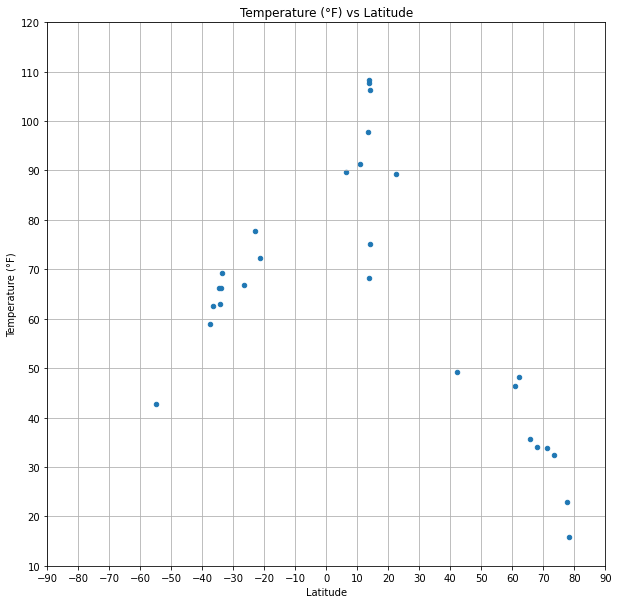

In [56]:
# Plotting Temperature (F) vs. Latitude

# Plot parameters

# X axis is fixed to show all possible latitude values
xticks = np.arange(-90,100,10)

# Y axis will contain max/min temperature values rounded to the closest 10
min_temp = (round(clean_weather_df['Temperature (°F)'].min()/10, 0))*10 - 10
max_temp = (round(clean_weather_df['Temperature (°F)'].max()/10,0))*10 + 10
yticks = np.arange(min_temp, max_temp+10, 10)

clean_weather_df.plot(kind="scatter", x="Latitude", y="Temperature (°F)", grid=True, figsize=(10,10),
                  title="Temperature (°F) vs Latitude", xticks= xticks, yticks= yticks)

print ("Possible correlation between temperature and latitude")

Possible correlation between humidity and latitude


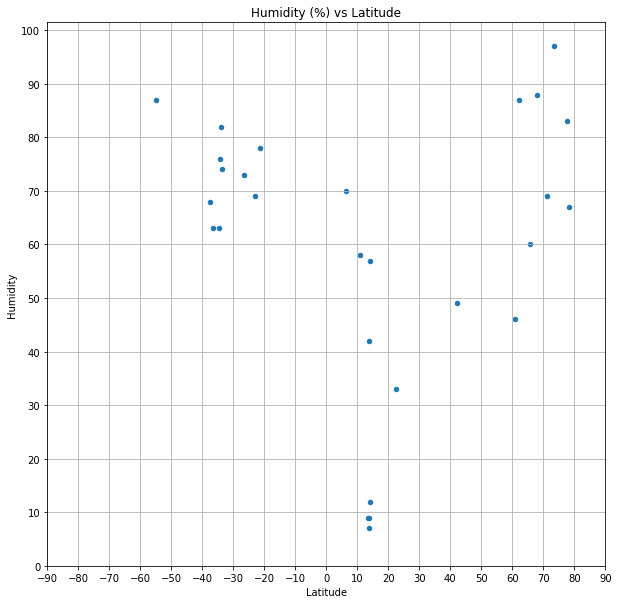

In [57]:
# Plotting Humidity (%) vs. Latitude

# Plot parameters

# X axis is fixed to show all possible latitude values
xticks = np.arange(-90,100,10)

# Y axis is a percentage will go from 0 to 100 always
yticks = np.arange(0,110,10)

clean_weather_df.plot(kind="scatter", x="Latitude", y="Humidity", grid=True, figsize=(10,10),
                  title="Humidity (%) vs Latitude", xticks= xticks, yticks= yticks)

print ("Possible correlation between humidity and latitude")


Possible correlation between cloudiness and latitude


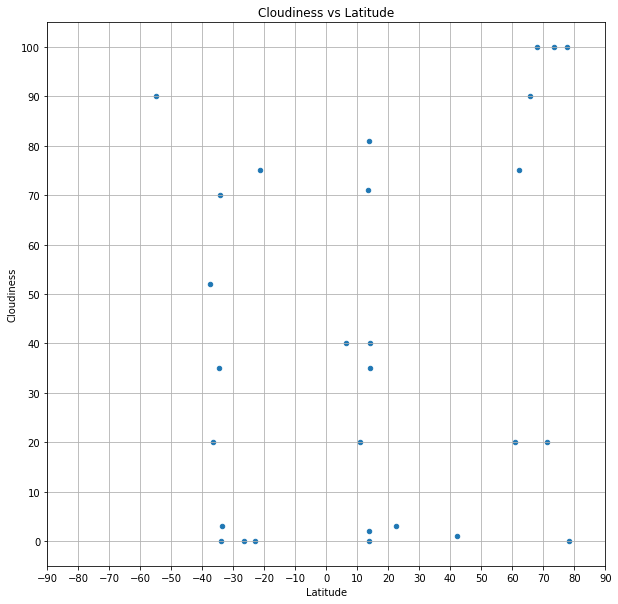

In [58]:
# Plotting Cloudiness (%) vs. Latitude

# Plot parameters

# X axis is fixed to show all possible latitude values
xticks = np.arange(-90,100,10)

# Y axis is a percentage will go from 0 to 100, but cloudiness can go to 100%, will adjust the axis to 105
yticks = np.arange(0,105,10)

clean_weather_df.plot(kind="scatter", x="Latitude", y="Cloudiness", grid=True, figsize=(10,10),
                  title="Cloudiness vs Latitude", xticks= xticks, yticks= yticks)

print ("Possible correlation between cloudiness and latitude")

Possible correlation between wind speed and latitude


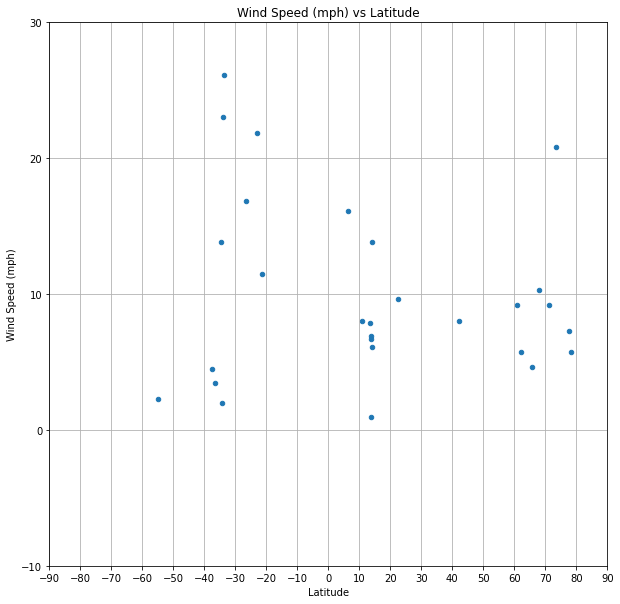

In [60]:
# Plotting Wind Speed (mph) vs. Latitude

# Plot parameters

# X axis is fixed to show all possible latitude values
xticks = np.arange(-90,100,10)

# Y axis will contain max/min wind speed values rounded to the closest 10
min_wind = (round(clean_weather_df['Wind Speed (mph)'].min()/10, 0))*10 - 10
max_wind = (round(clean_weather_df['Wind Speed (mph)'].max()/10,0))*10 + 10
yticks = np.arange(min_wind, max_wind, 10)

clean_weather_df.plot(kind="scatter", x="Latitude", y="Wind Speed (mph)", grid=True, figsize=(10,10),
                  title="Wind Speed (mph) vs Latitude", xticks= xticks, yticks= yticks)

print ("Possible correlation between wind speed and latitude")


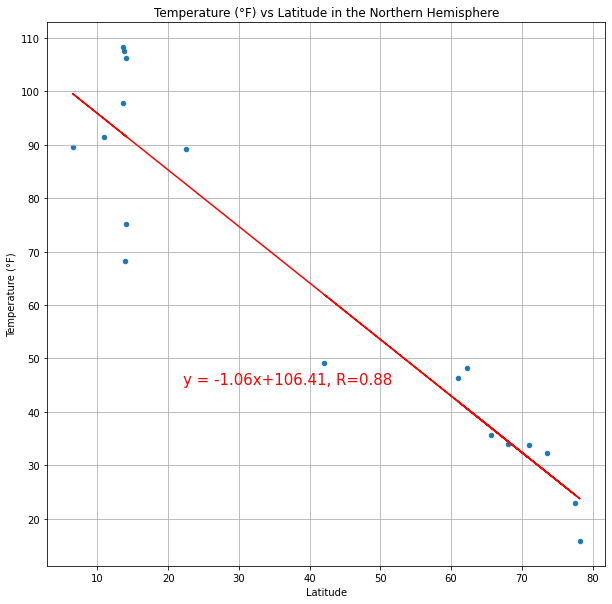

In [104]:
# Plotting Northern Hemisphere - Temperature (F) vs. Latitude

# Splitting the dataframe into north and south hemisphere
north_df = clean_weather_df.loc[clean_weather_df['Latitude'] >= 0]
south_df = clean_weather_df.loc[clean_weather_df['Latitude'] < 0]

# Plot parameters

# X axis is fixed to show all possible latitude values
xticks = np.arange(0,100,10)

# Y axis will contain max/min temp values rounded to the closest 10
min_temp = (round(clean_weather_df['Temperature (°F)'].min()/10, 0))*10 - 10
max_temp = (round(clean_weather_df['Temperature (°F)'].max()/10,0))*10 + 10
yticks = np.arange(min_temp, max_temp, 10)

north_df.plot(kind="scatter", x="Latitude", y="Temperature (°F)", grid=True, figsize=(10,10),
                  title="Temperature (°F) vs Latitude in the Northern Hemisphere", xticks= xticks, yticks= yticks)

# Setting x and y for line
x_values = north_df['Latitude']
y_values = north_df['Temperature (°F)']
(m, b, r, p, stderr) = st.stats.linregress(x_values, y_values)

# Building the line
line_eq = 'y = ' + str(round(m, 2)) + 'x+' + str(round (b, 2))
plt.annotate(line_eq + ', R=' + str(round(r**2, 2)),(22.1,45.2), fontsize=15,color="red")
plt.plot(x_values, m*x_values + b, color ='r')


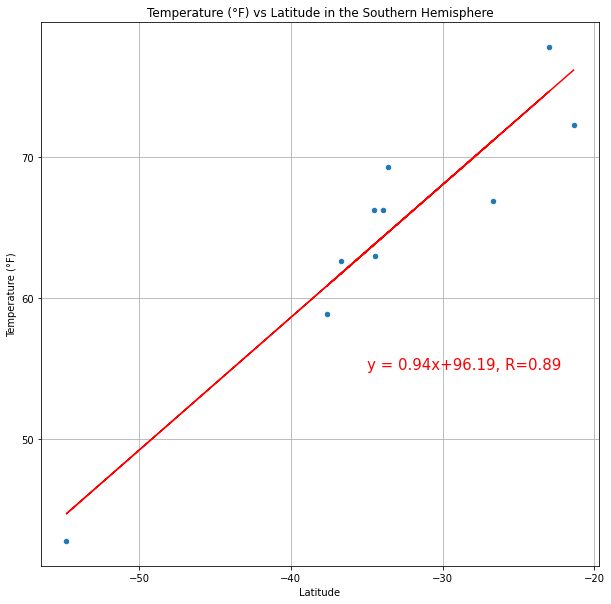

In [108]:
# Plotting Southern Hemisphere - Temperature (F) vs. Latitude

# Plot parameters

# X axis is fixed to show all possible latitude values
xticks = np.arange(-90,10,10)

# Y axis will contain max/min temp values rounded to the closest 10
min_temp = (round(south_df['Temperature (°F)'].min()/10, 0))*10 - 10
max_temp = (round(south_df['Temperature (°F)'].max()/10,0))*10 + 10
yticks = np.arange(min_temp, max_temp, 10)

south_df.plot(kind="scatter", x="Latitude", y="Temperature (°F)", grid=True, figsize=(10,10),
                  title="Temperature (°F) vs Latitude in the Southern Hemisphere", xticks= xticks, yticks= yticks)

# Setting x and y for line
x_values = south_df['Latitude']
y_values = south_df['Temperature (°F)']
(m, b, r, p, stderr) = st.stats.linregress(x_values, y_values)

# Building the line
line_eq = 'y = ' + str(round(m, 2)) + 'x+' + str(round (b, 2))
plt.annotate(line_eq + ', R=' + str(round(r**2, 2)),(-35, 55), fontsize=15,color="red")
plt.plot(x_values, m*x_values + b, color ='r')


In [ ]:
# Plotting Northern Hemisphere - Humidity (%) vs. Latitude

In [ ]:
# Plotting Southern Hemisphere - Humidity (%) vs. Latitude

In [ ]:
# Plotting Northern Hemisphere - Cloudiness (%) vs. Latitude

In [ ]:
# Plotting Southern Hemisphere - Cloudiness (%) vs. Latitude

In [ ]:
# Plotting Northern Hemisphere - Wind Speed (mph) vs. Latitude

In [ ]:
# Plotting Southern Hemisphere - Wind Speed (mph) vs. Latitude